# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 4:  Logistic Regression and PCA

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

**Partners: Sunil Kumar Shambulingaiah and Steven Devisch** 

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile


import seaborn as sns
sns.set()

# if you want to do a 2-sample t-test:
from scipy.stats import ttest_ind

<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The dataset is provided in the file `data/genomic_data.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [15 pts]: Data Exploration </b></div>

The first step is to split the observations into an approximate 75-25 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. `Cancer_type` is our target column.


**1.1** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands). To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1. **NOTE: for the entirety of this homework assignment, you will use these normalized values, not the original, raw values**. Normalizing genomic data is a fairly standard first step.


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a dataset? Explain in 3 or fewer sentences.


**1.3** Determine which single gene individually discriminates between the two cancer classes the best (consider every gene in the dataset) and call it `best_predictor`.

Plot two histograms of your `best_predictor` -- one using the training set and another using the testing set. The histogram should clearly distinguish two different `Cancer_type` classes.

**Hint:** You may use any reasonable approach to determine the `best_predictor`, but please use something very simple (whether taught in this class or elsewhere).


**1.4** Using `best_predictor`, create a classification model by simply eye-balling a value for this gene that would discriminate the two classes the best (do not use an algorithm to determine for you the optimal coefficient or threshold; we are asking you to provide a rough estimate / model by manual inspection). Justify your choice in 1-2 sentences. Report the accuracy of your hand-chosen model on the test set.

<hr> 


### Answers

**The first step is to split the observations into an approximate 75-25 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/genomic_data.csv', index_col=0)
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.25, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [4]:
print(df.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(df.Cancer_type.value_counts(normalize=True))

(752, 7130)
(564, 7129) (188, 7129) (564,) (188,)
0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


**Comment:** there seem to be more columns than rows. The dataset does seem to be balanced, 

**1.1 Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands). To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1. **NOTE: for the entirety of this homework assignment, you will use these normalized values, not the original, raw values.**


In [5]:
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,...,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,-117.907036,-163.527476,26.835753,210.370847,-248.657677,-406.595313,-28.764782,-190.080423,74.023263,94.750752,...,162.952887,698.676059,2.962852,415.726722,-50.791438,833.447504,329.612463,7.808718,520.229369,-24.088765
std,169.792429,189.691312,205.798155,205.008971,209.564816,258.448200,541.128517,162.728073,175.291394,356.386595,...,164.794952,521.178135,151.324810,580.873231,106.535986,820.213770,370.829412,84.859351,936.957523,72.056218
min,-894.789505,-1095.737090,-645.439001,-425.750627,-1154.285694,-1091.492494,-2066.516448,-728.996262,-770.025847,-1176.663615,...,-416.206278,-1010.430536,-447.077819,-1870.955269,-432.967768,-2151.593119,-651.051441,-255.419724,-2754.665185,-237.864216
25%,-225.038171,-274.322819,-95.270925,84.245857,-379.511872,-566.993723,-342.364586,-300.978001,-20.279803,-122.958169,...,68.056179,354.959208,-88.764266,96.448742,-105.297264,274.126036,89.320933,-41.845553,-49.150550,-73.781203
50%,-107.412549,-146.993065,20.548933,213.143203,-228.639073,-432.747578,-49.602631,-179.079214,88.038576,102.087963,...,153.844059,679.200114,8.707703,379.423043,-35.816408,776.498538,290.209261,7.337169,460.622697,-25.003950
75%,-6.157261,-43.097489,127.413838,331.513199,-115.153022,-251.990616,324.333687,-73.891345,186.391086,284.218792,...,265.721675,1058.612890,95.688864,718.826611,19.827732,1321.287958,520.922602,62.512588,1109.915839,20.020152
max,516.618491,384.626762,696.983127,1022.560525,308.876677,607.737258,1385.881293,263.634029,589.778466,1355.537180,...,686.321597,2522.188808,481.820516,3982.980299,215.047697,3743.264860,1996.244626,274.575647,3315.374276,224.773440


In [6]:
# archive column names as scale_transformer produces an array, removing column names
columns = X_train.columns
# scale the datasets
# use minmaxscalar as some predictors are negative
scale_transformer = MinMaxScaler(copy=True).fit(X_train)
X_train = pd.DataFrame(scale_transformer.transform(X_train))
X_test = pd.DataFrame(scale_transformer.transform(X_test))

# reapply columns
X_train.columns = columns
X_test.columns = columns

print(X_train.shape)
X_train.head()

(564, 7129)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.619351,0.945349,0.817396,0.841058,0.683758,0.360329,0.461770,0.601425,0.827058,0.225030,...,0.685016,0.504484,0.469944,0.105544,0.722699,0.631021,0.216853,0.742124,0.312083,0.621290
1,0.493430,0.593738,0.582163,0.475156,0.784989,0.183778,0.792969,0.795903,0.255178,0.549755,...,0.449506,0.303861,0.565232,0.494874,0.608248,0.480530,0.233495,0.704078,0.754073,0.485576
2,0.453711,0.638256,0.737430,0.665891,0.515745,0.427893,0.496062,0.488115,0.730907,0.546633,...,0.899386,0.550748,0.113228,0.094507,0.261622,0.418446,0.551573,0.821525,0.633380,0.623126
3,0.497778,0.726115,0.426631,0.408176,0.574250,0.315588,0.691303,0.698345,0.819778,0.446504,...,0.558269,0.372834,0.507707,0.391318,0.598964,0.568479,0.318087,0.495726,0.505263,0.486846
4,0.572308,0.685343,0.413806,0.432270,0.619183,0.612995,0.554375,0.674835,0.640734,0.475720,...,0.760584,0.516456,0.433381,0.508760,0.693013,0.509524,0.466636,0.561463,0.507653,0.467111


**1.2 The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a dataset? Explain in 3 or fewer sentences.**

It is likely the predictors are correlated. The parameters are unidentifiable. Predictions on the training set will be perfect, but not on the test set.

**1.3 Determine which single gene individually discriminates between the two cancer classes the best (consider every gene in the dataset) and call it `best_predictor`.**

**Plot two histograms of your `best_predictor` -- one using the training set and another using the testing set. The histogram should clearly distinguish two different `Cancer_type` classes.**

In [7]:
best_accuracy = -1
best_model = None

predictors = X_train.columns
for predictor in predictors:
    
    logref = LogisticRegression(solver='liblinear', max_iter=1000, C=100000)
    logref.fit(X_train[predictor].values.reshape(-1, 1), y_train)
    y_hat_test = logref.predict(X_test[predictor].values.reshape(-1, 1))
    cur_accuracy = accuracy_score(y_test.to_numpy(), y_hat_test)

    if cur_accuracy > best_accuracy:
        best_accuracy = cur_accuracy
        best_model = logref
        best_predictor = predictor

In [8]:
print("Best found logistic regression model:", best_model,"\nAccuracy score:", best_accuracy)

Best found logistic regression model: LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 
Accuracy score: 0.7340425531914894


In [9]:
print("The best found logistic regression model uses this variable:", best_predictor)

The best found logistic regression model uses this variable: Y08612_at


Text(0.5, 0.98, 'Histogram comparions between train and test set for best predictor: Y08612_at')

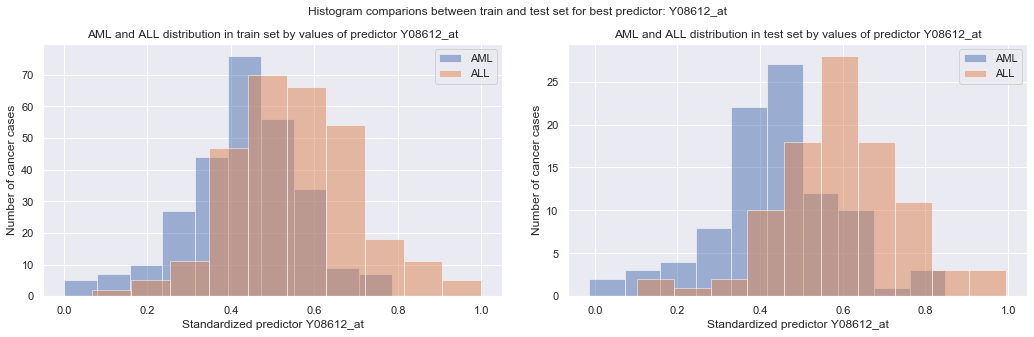

In [10]:
# 2 graphs side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# historgram on training set 
ax[0].hist(X_train[best_predictor][y_train.values==1], alpha=0.5, label = 'AML')
ax[0].hist(X_train[best_predictor][y_train.values==0], alpha=0.5, label = 'ALL')
ax[0].set_xlabel('Standardized predictor ' +  best_predictor)
ax[0].set_ylabel('Number of cancer cases')
ax[0].set_title('AML and ALL distribution in train set by values of predictor ' +  best_predictor)
ax[0].legend()

ax[1].hist(X_test[best_predictor][y_test.values==1], alpha=0.5, label = 'AML')
ax[1].hist(X_test[best_predictor][y_test.values==0], alpha=0.5, label = 'ALL')
ax[1].set_xlabel('Standardized predictor ' +  best_predictor)
ax[1].set_ylabel('Number of cancer cases')
ax[1].set_title('AML and ALL distribution in test set by values of predictor ' +  best_predictor)
ax[1].legend()

fig.tight_layout(pad=3.0)
fig.suptitle("Histogram comparions between train and test set for best predictor: " + best_predictor, fontsize=12)

**Comment**: The histograms for bot the train and test set demonstrat how the best predictor correlates more with ALL at higher values of the predictor, and more with AML at lower values.

**1.4 Using `best_predictor`, create a classification model by simply eye-balling a value for this gene that would discriminate the two classes the best (do not use an algorithm to determine for you the optimal coefficient or threshold; we are asking you to provide a rough estimate / model by manual inspection). Justify your choice in 1-2 sentences. Report the accuracy of your hand-chosen model on the test set.**


In [11]:

# default to ALL
y_hat_test[:] = 0

# set threshold for ALL above 0.5
thresh = 0.5
AML_indices = X_test[best_predictor].values > thresh
# set to AML if predictor exceeds the threshold value
y_hat_test[AML_indices] = 1

#@Sunil something's wrong in this calculation. Accuracy should be closer to 66% (see below)
eyeball_accuracy = accuracy_score(y_hat_test, y_test.to_numpy())
print("The eye-ball model has an accuracy of: " + str(eyeball_accuracy) + " on the test set")

The eye-ball model has an accuracy of: 0.25 on the test set


---

<div class='exercise'> <b> Question 2 [35pts]: Logistic Regression Modeling </b> </div>


**2.1** Fit a simple logistic regression model to the training set using the single gene predictor `best_predictor` to predict cancer type.  Carefully interpret the coefficient estimates for this model.

*Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use `C=100000` or `penalty = "none"`).

**2.2** Plot the logistic curves for the model in 2.1 ($y$-axis is probability scale, $x$-axis is `best_predictor`).  Interpret this plot: at what values of your `best_predictor` will you predict the patient to have ALL?  How does this compare to your eeballed value from 1.4?

**2.3** Calculate the training and test classification accuracies of this model in 2.1. How do these compare to the eye-balled model from 1.4?


**2.4** Next, fit a multiple logistic regression model with **all** the gene predictors from the data set (reminder: for this assignment, we are always using the normalized values). How does the classification accuracy of this model compare with the models fitted with a single gene (on both the training and test sets)?  

**2.5** Print out and interpret the logistic regression coefficients for  `best_predictor` from both the simple logistic and multiple logistic regression models from the previous two parts.  Do they agree or disagree?  What does this indicate?

**2.6** Now let's use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and 5-fold cross-validation to fit the model on the training set (choose between 20 reasonable values of $\lambda$). Report the classification accuracy on both the training and testing set.

**2.7** How many predictors are considered as important features in this regularized model?  What does that say about the full logistic regression model in problem 2.4?


## Answers

**2.1 Fit a simple logistic regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. Carefully interpret the coefficient estimates for this model.**

In [12]:
logreg = LogisticRegression(solver='liblinear', max_iter=1000, C=100000)
logreg.fit(X_train[best_predictor].values.reshape(-1, 1), y_train)
y_hat_test = logreg.predict(X_test[best_predictor].values.reshape(-1, 1))
cur_accuracy = accuracy_score(y_test.to_numpy(), y_hat_test)
print("Accuracy for a model with 'best' predictor " + best_predictor + " is: " + str(cur_accuracy))
print(logref.coef_)

Accuracy for a model with 'best' predictor Y08612_at is: 0.7340425531914894
[[1.60120164]]


In [13]:
# convert log odds into odds for the coeffinet associated with the best predictor
odds = np.exp(logreg.coef_[0])

**Coefficient interpretation:** For every one-unit increase in the best predictor 'Y08612_at', the odds that the observation is in AML are 0.00233 times as large as the odds that the observation is not in AML when all other variables are held constant.

**2.2 Plot the logistic curves for the model in 2.1 ($y$-axis is probability scale, $x$-axis is `best_predictor`).  Interpret this plot: at what values of your `best_predictor` will you predict the patient to have ALL?  How does this compare to your eeballed value from 1.4?**


[Text(0, 0.5, 'Probability'),
 Text(0.5, 0, 'Best predictor: Y08612_at'),
 Text(0.5, 1.0, 'Logistic curve for the best predictor model')]

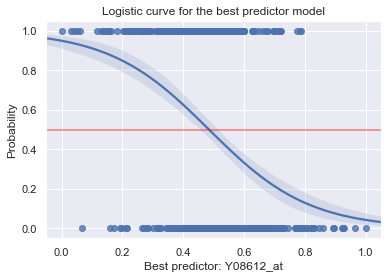

In [14]:
# seaborn provides a convenient method to plotting logistic curves
sbplt = sns.regplot(x=X_train[best_predictor], y=y_train.values, logistic=True)
# add a horizontal line at the cut-off point
sbplt.axhline(0.5, c='red', alpha=0.5)
sbplt.set(xlabel='Best predictor: ' + best_predictor, ylabel='Probability', title='Logistic curve for the best predictor model')

**Comment**: We observe that the prediction flips at a Y08612_at value of a little bit below 0.5. This is similar to our ealier guess. At values below 0.5 for standardized Y08612_at, we predict a patient to have ALL.

**2.3 Calculate the training and test classification accuracies of this model in 2.1.  How do these compare to the eye-balled model from 1.4?**

In [15]:
# calculate training accuracies
y_hat_train = logreg.predict(X_train[best_predictor].values.reshape(-1, 1))
train_accuracy = accuracy_score(y_train.to_numpy(), y_hat_train)
print("Accuracy on the training set is:", train_accuracy)

# calculate test accuracies
y_hat_test = logreg.predict(X_test[best_predictor].values.reshape(-1, 1))
test_accuracy = accuracy_score(y_test.to_numpy(), y_hat_test)
print("Accuracy on the test set is:", test_accuracy)

Accuracy on the training set is: 0.6648936170212766
Accuracy on the test set is: 0.7340425531914894


**Comment:** The eyeballed model and the logistic regression model perform similarly. This seems reasonable. 


**2.4 Next, fit a multiple logistic regression model with *all* the gene predictors from the data set (reminder: for this assignment, we are always using the normalized values). How does the classification accuracy of this model compare with the models fitted with a single gene (on both the training and test sets)?**


In [16]:
# fit a model with all predictors (without regularizing)
logreg_all = LogisticRegression(solver='liblinear', max_iter=1000, C=100000)
logreg_all.fit(X_train, y_train)

# calculate training accuracies
y_hat_train = logreg_all.predict(X_train)
train_accuracy = accuracy_score(y_train.to_numpy(), y_hat_train)
print("Accuracy on the training set is:", train_accuracy)

# calculate test accuracies
y_hat_test_all = logreg_all.predict(X_test)
test_accuracy = accuracy_score(y_test.to_numpy(), y_hat_test_all)
print("Accuracy on the test set is:", test_accuracy)


Accuracy on the training set is: 1.0
Accuracy on the test set is: 0.7925531914893617


**Comment:** As anticipated above since there are more predictors than observations, model accuracy for the training set becomes 100%. Model accuracy for the test set has increased as well.

**2.5 Print out and interpret the logistic regression coefficients for `best_predictor` from both the simple logistic and multiple logistic regression models from the previous two parts.  Do they agree or disagree?  What does this indicate?**

In [17]:
logreg_all.coef_

array([[ 0.44665596,  0.25503626, -0.27250935, ..., -0.13285564,
         0.342134  ,  0.23650392]])

In [18]:
# store the position of the best predictor
best_pred_pos = X_train.columns.get_loc(best_predictor)

# coef_list = np.ndarray.tolist(logreg_all.coef_)
# coef_list[0][best_pred_pos]
print('The coefficient for best_predictor in simple logistic regression is:', logref.coef_[0][0])
print('The coefficient for best_predictor in multiple logistic regression is:', logreg_all.coef_[0][best_pred_pos])



The coefficient for best_predictor in simple logistic regression is: 1.6012016388142722
The coefficient for best_predictor in multiple logistic regression is: -0.6156007681999647


**Comment:** The coefficients for simple and multiple logistic regression are very different. This is likely due to high collinearity between the different variables.

**2.6 Now let's use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and 5-fold cross-validation to fit the model on the training set (choose between 20 reasonable values of $\lambda$). Report the classification accuracy on both the training and testing set.**

In [43]:
#Your answer
best_accuracy = -1
best_model = None
accuracies = []

# experiment with different values of different order of magnitudes
cs_vals = np.ndarray.tolist((np.ones(20)*10)**np.arange(-10,10,1).astype(int))
# overriding cs_vals as only integers work
cs_vals = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,1000]
# subseting cvals to lower number as 20 take long to compute
cs_vals = [4,5,6]

# adding a solver choice in case we also want to experiment with different solvers
solvers = ['liblinear']
for c in cs_vals:
    for sol in solvers:
        # use l1 for lasso and 5 cross validation (cv) folds
        logref =  LogisticRegressionCV(Cs=c, solver=sol, penalty='l1', cv=5)
        logref.fit(X_train, y_train)
        y_hat_test = logref.predict(X_test)
        cur_accuracy = accuracy_score(y_test.to_numpy(), y_hat_test)
        
        # adding accuracy to a list in case we want to show how accuracy changes with lambda
        accuracies.append(cur_accuracy)
        if cur_accuracy > best_accuracy:
            best_accuracy = cur_accuracy
            best_reg_model = logref
            best_lambda = c
            
# predictions
y_train_pred = best_reg_model.predict(X_train) 
y_test_pred = best_reg_model.predict(X_test)

# accuracy
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)

In [21]:
print("The best lambda was:", best_lambda)
print("Errors on the training set were:", train_score)
print("Errors on the test set were:",test_score)

The best lambda was: 6
Errors on the training set were: 0.900709219858156
Errors on the test set were: 0.8776595744680851


**Comment**: after regularization, test scores improved significantly

**2.7 How many predictors are considered as important features in this regularized model?  What does that say about the full logistic regression model in problem 2.4?**


In [22]:
# calculate the number of non-zero coeffients in the model
print("The number of non-zero coefficients in the model is:", sum(x > 0 for x in best_model.coef_[0]))

The number of non-zero coefficients in the model is: 19


**Comment** The regularized model retained nineteen predictors. We can conclude that the initial predictor set - as used in the full logistic regression model - was highly correlated.

---

<div class='exercise'> <b> Question 3 [10pts]: $k$-NN Classification </b> </div>

**3.1** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,3,5,7,10,15,20,50,100]`. 

**3.2** Provide the confusion matrix for 3 models: (i) the full multiple logistic regression model from 2.4, (ii) the best regularized model from 2.6, and (iii) the best $k$-NN from the previous part. Report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


### Answers

**3.1 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,3,5,7,10,15,20,50,100]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [36]:
ks = [1,3,5,7,10,15,20,50,100]
cv_folds = 5
best_accuracy = -1
acc = []

for k in ks:
    knn_model = KNeighborsClassifier(k)
    cur_accuracy = np.mean(cross_val_score(knn_model, X_train, y_train, cv=cv_folds))
    acc.append(cur_accuracy)
    if cur_accuracy > best_accuracy:
        best_accuracy = cur_accuracy
        best_knn_model = knn_model 
        best_k = k

Text(0, 0.5, 'Classification accuracy')

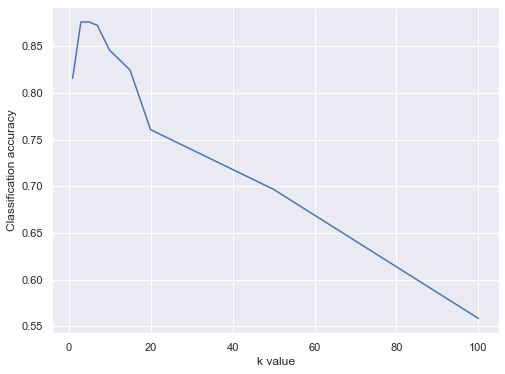

In [37]:
plt.figure(figsize = (8,6))    
plt.plot(ks, acc)
plt.xlabel('k value')
plt.ylabel('Classification accuracy')

In [42]:
print("The best value for k is: ", best_k)
print("Classification accuracy for this k:", best_accuracy)

The best value for k is:  3
Classification accuracy for this k: 0.8758059418457649


**3.2 Provide the confusion matrix for 3 models: (i) the full multiple logistic regression model from 2.4, (ii) the best regularized model from 2.6, and (iii) the best $k$-NN from the previous part. what are the  false positive and false negative rates in these 3 models (all in the test set)?  Briefly interpret what you notice.**

In [70]:
# helper function to calculate false positive and false positive rates
def calc_confusion_rate(confusion_matrix):
        TP = confusion_matrix.loc['true:0','pred:0']
        TN =  confusion_matrix.loc['true:1','pred:1']        
        FP =  confusion_matrix.loc['true:1','pred:0']
        FN =  confusion_matrix.loc['true:0','pred:1']
        FP_rate = FP / (FP+TN)
        FN_rate = FN / (FN+TP)
        return FP_rate, FN_rate

In [71]:
# set the set of models and rates we seek to explore
models = [logreg_all, best_reg_model, best_knn_model]
model_descriptions = ['Full_logistic', 'Regularized_bLogistic', 'KNN']
confusion_rates = ['False_Positive_Rate', 'False_Negative_Rate']

In [80]:
# prepare a dataframe to represent rates for each model
confusion_rate_df = pd.DataFrame(
    index=model_descriptions,
    columns=['False_Positive_Rate', 'False_Negative_Rate']
)





,False_Positive_Rate,False_Negative_Rate
Full_logistic,nan,nan
Regularized_Logistic,nan,nan
KNN,nan,nan


In [81]:
index = 0
for model in models:
    # confusion matrix for model with all predictors
    model.fit(X_train,y_train)
    y_hat_test = model.predict(X_test)
    conf_df = pd.DataFrame(
        metrics.confusion_matrix(y_test, y_hat_test), 
        index=['true:0', 'true:1'], 
        columns=['pred:0', 'pred:1'])
    curr_model_descr = model_descriptions[index]
    print("\n Confusion matrix for:", curr_model_descr,"\n")

    # calculate false positive and false negative rate
    FP_rate, FN_rate = calc_confusion_rate(conf_df)
    
    # Add rates to dataframe for clear comparison 
    confusion_rate_df.loc[curr_model_descr,'False_Positive_Rate'] = FP_rate
    confusion_rate_df.loc[curr_model_descr,'False_Negative_Rate'] = FN_rate
    print(conf_df)
    index = index + 1


 Confusion matrix for: Full_logistic 

        pred:0  pred:1
true:0      83      13
true:1      26      66

 Confusion matrix for: Regularized_Logistic 

        pred:0  pred:1
true:0      85      11
true:1      12      80

 Confusion matrix for: KNN 

        pred:0  pred:1
true:0      83      13
true:1      18      74


,False_Positive_Rate,False_Negative_Rate
Full_logistic,0.282609,0.135417
Regularized_Logistic,0.130435,0.114583
KNN,0.195652,0.135417


In [85]:
# display the rates by model in percentage format
confusion_rate_df.style.format({
    'False_Positive_Rate': '{:,.1%}'.format,
    'False_Negative_Rate': '{:,.1%}'.format,
})

,False_Positive_Rate,False_Negative_Rate
Full_logistic,28.3%,13.5%
Regularized_Logistic,13.0%,11.5%
KNN,19.6%,13.5%


In [58]:
#In sklearn, to obtain the confusion matrix in the standard form, always have the observed y first, 
# i.e.: use as confusion_matrix(y_true, y_pred)

# confusion matrix for model with all predictors
logreg_all.fit(X_train,y_train)
y_logregall_test = logreg_all.predict(X_test)
conf_logregall_log = pd.DataFrame(
    metrics.confusion_matrix(y_test, y_logregall_test), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)

print("Confusion matrix for logistic regression model with all predictors:")
conf_logregall_log

Confusion matrix for logistic regression model with all predictors:


,pred:0,pred:1
true:0,83,13
true:1,26,66


In [68]:
# prepare a dataframe allowing comparison of false positive and false negative rates
confusion_rate_df = pd.DataFrame(
    index=['Full_logistic', 'Regularized_Logistic', 'KNN'], 
    columns=['False_Positive_Rate', 'False_Negative_Rate']
)


In [69]:


FP_rate, FP_rate = calc_confusion_rate(conf_logregall_log)
confusion_rate_df.loc['Full_logistic','False Positive Rate'] = FP_rate
confusion_rate_df.loc['Full_logistic','False Negative Rate'] = FN_rate

print(confusion_rate_df)

                     False Positive Rate False Negative Rate
Full_logistic                   0.135417            0.135417
Regularized_Logistic                 NaN                 NaN
KNN                                  NaN                 NaN


In [47]:
#In sklearn, to obtain the confusion matrix in the standard form, always have the observed y first, 
# i.e.: use as confusion_matrix(y_true, y_pred)

# confusion matrix for regularized logistic regression model
best_reg_model.fit(X_train,y_train)
y_bestreg_test = best_reg_model.predict(X_test)
conf_bestreg_log = pd.DataFrame(
    metrics.confusion_matrix(y_test, y_bestreg_test), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)

print("Confusion matrix for regularized logistic regression model:")
conf_bestreg_log

Confusion matrix for regularized logistic regression model:


,pred:0,pred:1
true:0,85,11
true:1,12,80


In [46]:
# Confusion matrix for knn model
best_knn_model.fit(X_train,y_train)
y_knn_test = best_knn_model.predict(X_test)
conf_knn_log = pd.DataFrame(
    metrics.confusion_matrix(y_test, y_knn_test), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)

print("Confusion matrix for knn model:")
conf_knn_log

Confusion matrix for knn model:


,pred:0,pred:1
true:0,83,13
true:1,18,74


**Comment** 

---

#### <div class='exercise'><b> Question 4 [15 pts]: Performing Principal Components Analysis </b></div>

**4.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

*Hint: be sure to standardize before performing PCA.

**4.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different colors and markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**4.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).  Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony. 



### Answers

**4.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [ ]:
######
# your code here
######

*Your answer here*


**4.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

In [ ]:
######
# your code here
######

*your answer here*


**4.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).  Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony.**

In [ ]:
######
# your code here
######

*your answer here*

---

<div class='exercise'><b> Question 5 [10 pts]: Principal Components Regression (PCR) </b></div>

**5.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors you chose from 5.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with these models?

**5.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `best_predictor` and `Cancer_type`.



### Answers

**5.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors you chose from 5.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with these models?**

In [ ]:
######
# your code here
######


*your answer here*


**5.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between your `best_predictor` and `Cancer_type`**.

In [ ]:
######
# your code here
######


* your answer here*

<div class='exercise'><b> Question 6 [15 pts]: Evaluating Classifiers </b></div>

**6.1**: Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**6.2** Evaluate the 'best' models (best based on test misclassification: if there is a tie, choose the 'simplest' model) from each class of classification models using AUC.  That is calculate AUC for the following models:
- the best logistic regression model, whether regularized or not (question 2)
- the best $k$-NN model (question 3)
- the best PCR model (question 5)

For the model with the best AUC, plot the ROC. Briefly interpret your plot.

**6.3** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

*See extra information about ALL and AML at the bottom of this notebook.*

### Answers

**6.1 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

*your answer here*


**6.2 use AUC to evaluate the 'best' models (best based on test misclassification: if there is a tie, choose the 'simplest' model) from each class of classification models.  That is calculate AUC for the following models:**
- the best logistic regression model, whether regularized or not (question 2)
- the best $k$-NN model (question 3)
- the best PCR model (question 5)

**For the model with the best AUC, plot the ROC. Briefly interpret your plot.**



In [ ]:
######
# your code here
######


*your answer here*

**6.3 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?**

*your answer here*


<hr style="height:2pt">


**Additional Information**

Acute Lymphoblastic Leukemia (ALL):
- About 98% of children with ALL go into remission within weeks after starting treatment.
- About 90% of those children can be cured. Patients are considered cured after 10 years in remission.

Acute Myeloid Leukemia (AML):
- In general, children with AML are seen as lower risk than adults. 
- Around 85 to 90 percent of children with AML will go into remission after induction, according to the American Cancer Society. AML will return in some cases.  
- The five-year-survival-rate for children with AML is 60 to 70 percent.

<hr style="height:2pt">